## Prueba NG Solve

Simulación

Primero se debe llamar a la gui (graphical user interphace), así esta se abre y luego cualquier simulación se observará en ella

In [31]:
# Correr desde jupyter web

from ngsolve import *
from netgen.csg import *
from ngsolve.webgui import Draw 
from ngsolve.krylovspace import CGSolver

In [1]:
# Correr desde vscode

from ngsolve import *
from netgen.csg import *
import netgen.gui
from netgen.geom2d import SplineGeometry
from ngsolve.krylovspace import CGSolver
from time import sleep
from ngsolve.solvers import *

importing NGSolve-6.2.2204
optfile ./ng.opt does not exist - using default values
togl-version : 2
OCC module loaded
loading ngsolve library
NGSolve-6.2.2204
Using Lapack
Including sparse direct solver UMFPACK
Running parallel using 8 thread(s)


In [20]:
def initial_conds(num):
    if num==1:
        v0 = 1 + 0.5*cos(4*pi*x) * cos(4*pi*y)
        w0 = 1 + 0.5*cos(8*pi*x) * cos(8*pi*y)
        T = 5
        D = 0.5
        a = 0.15
        b = 1
        lamb = -100
        thet = 0.4
        params = (T, D, a, b, lamb, thet)
        h = 1/32; CFL = 32 / 40
        return v0, w0, params, h, CFL
    
    elif num==2:
        v0 = 1 - 1 / (1 + exp(-50 * sqrt(x**2 + y**2) - 0.1))
        w0 = 0
        T = 5
        D = 1
        a = 0.16875
        b = 1
        lamb = -100
        thet = 0.25
        params = (T, D, a, b, lamb, thet)
        h = 1/32; CFL = 32 / 80
        return v0, w0, params, h, CFL

    elif num==3:
        v0 = IfPos(0.5 - x, IfPos(0.5 - y, 1.4, 0), 0)
        w0 = IfPos(x - 0.5, IfPos(0.5 - y, 0.15, 0), 0)
        T = 15
        D = 1
        a = 0.15
        b = 1
        lamb = -100
        thet = 0.25
        params = (T, D, a, b, lamb, thet)
        h = 1/32; CFL = 32 / 40
        return v0, w0, params, h, CFL

    else:
        v0 = 1 + 0.5*cos(4*pi*x) * cos(4*pi*y)
        w0 = 0#1 + 0.5*cos(8*pi*x) * cos(8*pi*y)
        T = 3
        D = 0.5
        a = 0.15
        b = 1
        lamb = -100
        thet = 0.4
        params = (T, D, a, b, lamb, thet)
        h = 1/512; CFL = 1/2
        return v0, w0, params, h, CFL

def solve_FHN1(v0, w0, params, h=0.1, CFL=0.3, order=3, num=1):
    """
    Usa euler explicito.
    """
    T, D, a, b, lamb, thet = params
    
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))  
    V = H1(mesh, order=order) # espacio de funciones con derivada integrable para 1ra ecuacion
    Q = H1(mesh, order=order) # espacio de funciones con derivada integrable para 2da ecuacion
    
    X = V*Q # espacio producto
    (v, w), (p, q) = X.TnT() # funciones trial y test


    c = BilinearForm(X)
    c += (D * grad(v) * grad(p)) * dx # primera ecuacion fitshugh-nagumo estatica (sin tiempo)
    c += (-lamb * (w - v * (1 - v) * (v - thet))) * p * dx # corriente ionica
    c += -(b*w - a*v) * q * dx # segunda ecuacion fitshugh-nagumo estatica 
    c

    time = 0; dt = CFL*h
    l = LinearForm(X)
    if num == 1:
        l += 0 * p * dx
    elif num == 2:  # Codicion de frontera experimento num. 2
        f = IfPos((x - 0.5)**2 + (y - 0.5)**2 - 0.04, 0, 5)
        l += f * p * dx
    l.Assemble()

    m = X.Mass(1)
    minv = m.Inverse()

    gfu = GridFunction(X)
    gfu.components[0].Set(v0) # Se fija condicion inicial v
    gfu.components[1].Set(w0) # Se fija condicion inicial w

    Draw(gfu.components[0], mesh, "v", autoscale=True)

    res = gfu.vec.CreateVector()

    if num == 2:
        stop = 1 * dt # Cuanto tiempo se mantiene el impulso f
        while time + dt/2 <= T:
            #aux = gfu.vec.CreateVector()
            #c.Apply(gfu.vec, aux)
            #c.Assemble()
            #res.data = minv * (-dt * c.mat*gfu.vec)
            #gfu.vec.data += res
            res.data = minv * (-dt * c.mat*gfu.vec)
            gfu.vec.data += res
            time += dt
            if stop <= time <= stop + dt:
                l += - f * p * dx
                l.Assemble()
            Redraw()
            sleep(dt/3)    # ajustar para que se cargue mas lento el grafico
    elif num==1:
        while time + dt/2 <= T:
            #aux = gfu.vec.CreateVector()
            #c.Apply(gfu.vec, aux)
            #c.Assemble()
            #res.data = minv * (-dt * c.mat*gfu.vec)
            #gfu.vec.data += res
            res.data = minv * (-dt * c.mat*gfu.vec)
            gfu.vec.data += res
            time += dt
            Redraw()
            sleep(dt)      # ajustar para que se cargue mas lento el grafico
    else:
        while time + dt/2 <= T:
            res.data = minv * (-dt * c.mat*gfu.vec)
            gfu.vec.data += res
            time += dt
            Redraw()
            sleep(dt / 10)      # ajustar para que se cargue mas lento el grafico
        return gfu, mesh
    return gfu

### Resolvemos la ecuación
Cambiar la variable ```num``` entre 1, 2 y 3 resolvera el problema para los distintos casos propuestos en el informe

In [21]:
num = 3
v0, w0, params, h, CFL = initial_conds(num)
gfu = solve_FHN1(v0, w0, params, h=h, CFL=CFL, order=1, num=num)

 Face 1 / 1 (parameter space projection)


TypeError: matrix not ready - assemble bilinearform first

: 

### Impulso en tiempo t=0.004

In [10]:
mesh = Mesh(unit_square.GenerateMesh(maxh=1/32))
f = IfPos((x - 0.5)**2 + (y - 0.5)**2 - 0.04, 0, 1)
Draw(f, mesh, 'u', order=3)

 Face 1 / 1 (parameter space projection)


# Convergencia

Las condiciones asociadas a ```num=4``` contienen las mismas condiciones que para el experimento 1, pero con ```h=1/512``` y ```CFL=1/2```.

In [50]:
num = 4
v0, w0, params, h, CFL = initial_conds(num)
gfu, mesh = solve_FHN1(v0, w0, params, h=h, CFL=CFL, order=1, num=num)

 Face 1 / 1 (parameter space projection)
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-spa

In [51]:
import numpy as np

errors = []
CFLs = [2, 1.5, 1, 0.5]
hsizes = np.array([0.2, 0.1, 0.05, 0.025])

for CFL in CFLs:
    l = []
    for hh in hsizes:
        sol, m = solve_FHN1(v0, w0, params, h=hh, CFL=CFL, order=1, num=4)
        err1 = Integrate((sol.components[0]-gfu.components[0])*(sol.components[0]-gfu.components[0]), m)
        err2 = sqrt(err1)
        l.append(err2)
    errors.append(l)

 Face 1 / 1 (parameter space projection)
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-spa

In [52]:
import numpy as np
hsizes = np.array([0.2, 0.1, 0.05, 0.025])

def convergence_rate_2(h, CFLs, err):
    rate = np.zeros((len(CFLs), len(h)))
    for j in range(len(CFLs)):
        l = err[j]
        for i in range(1,len(h)):
            rate[j, i] = (np.log10(l[i])-np.log10(l[i-1]))/(np.log10(h[i])-np.log10(h[i-1]))
    return np.round(rate, 3)

import pandas as pd

r1 = pd.DataFrame(index=CFLs, columns=hsizes , data=convergence_rate_2(hsizes, CFLs, errors)).T
display(r1)

,2.0,1.5,1.0,0.5
0.200,0.000,0.000,0.000,0.000
0.100,0.150,0.142,0.150,0.157
0.050,0.663,0.661,0.660,0.658
0.025,1.463,1.461,1.458,1.456


In [57]:
r2 = pd.DataFrame(index=CFLs, columns=hsizes , data=errors).T
display(np.round(r2, 4))

,2.0,1.5,1.0,0.5
0.200,0.2594,0.2571,0.2575,0.2579
0.100,0.2337,0.2329,0.2321,0.2313
0.050,0.1476,0.1473,0.1470,0.1466
0.025,0.0535,0.0535,0.0535,0.0535


<AxesSubplot:>

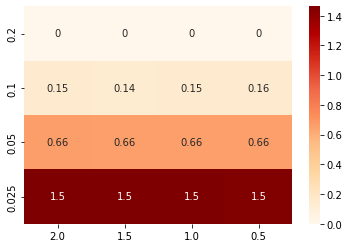

In [55]:
import seaborn as sn
sn.heatmap(r1, annot=True,cmap="OrRd")

<AxesSubplot:>

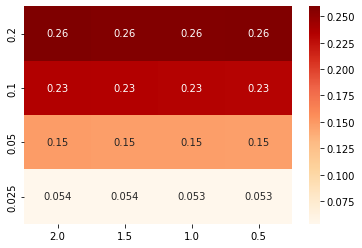

In [56]:
sn.heatmap(r2, annot=True,cmap="OrRd")

In [20]:
errors = []

for hh in [0.2, 0.1, 0.05, 0.025]:
    sol, m = solve_FHN1(v0, w0, params, h=hh, CFL=CFL, order=1, num=4)
    err1 = Integrate((sol.components[0]-gfu.components[0])*(sol.components[0]-gfu.components[0]), m)
    err2 = Integrate((sol.components[1]-gfu.components[1])*(sol.components[1]-gfu.components[1]), m)
    err3 = sqrt(err1 * err2)
    print("Error L2:", err3)
    errors.append(err3)


 Face 1 / 1 (parameter space projection)
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-space, not for N6ngcomp18H1HighOrderFESpaceE
SolveM is only available for L2-spa